# **Analyze Traffic Safety Data with Python**

## **Overview**
This case study takes you through an analysis of car collision rates and smartphone usage over time. 

## **Objective:**

* visualize time-series data
* do exploratory data analysis
* use linear regression for prediction
* compare predicted and actual outcomes

## **Datasets**

One dataset we’re working with comprises monthly total numbers of collisions in the United States from 2006 to 2020 normalized to the population size. This dataset was cleaned and modified to aggregate collisions with different outcomes to streamline our analysis. The original data can be found on the [National Highway Traffic Safety Administration’s](https://cdan.nhtsa.gov/query) website.

A second dataset we’ll work with comprises the quarterly percent of American adults that report owning and using a smartphone. This dataset has been cleaned and modified to only include information relevant to our analyses. The unaltered data can be found on the [Pew Research Center’s](https://www.pewresearch.org/internet/fact-sheet/mobile/) website.


In [1]:
import pandas as pd
import datetime as dt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
# set plot theme and palette
sns.set_theme()
sns.set_palette('colorblind')

## **Traffic data exploration**

### 1. Inspect the traffic safety dataset

After running the first cell to load all necessary libraries, we need to load our dataset. Using pandas, load the dataset `traffic.csv` and save it as `traffic`. Inspect the first few rows.

In [2]:
# load dataset
traffic = pd.read_csv('traffic.csv')

# inspect first few rows
traffic.head()

,Date,Crashes_per_100k,Season
0,2006-01-01,169.176541,Winter
1,2006-02-01,154.028836,Winter
2,2006-03-01,159.930002,Spring
3,2006-04-01,155.741270,Spring
4,2006-05-01,168.179208,Spring


### 2. Inspect and format data types

The `traffic` data frame contains three columns: `Date`, `Crashes_per_100k`, and `Season`. In order to plot the `Crashes_per_100k` column as a time series, we need to make sure that the `Date` column is in date format. Inspect the data types in the data frame, convert the `Date` column to date format, and inspect the data types a second time.

In [23]:
# inspect data types
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              180 non-null    object 
 1   Crashes_per_100k  180 non-null    float64
 2   Season            180 non-null    object 
dtypes: float64(1), object(2)
memory usage: 4.3+ KB


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

The `traffic` dataframe consists of 3 columns and 180 rows. Luckily, there are no missing data to contend with. The number of crashes is normalized to the annual population per 100,000 people. We will also need to format the `Date` variable since Python does not yet recognize it as a datetime variable.


</details>

Convert the `Date` column to the date datatype using the `pd.to_datatime(column)` function.

In [24]:
# convert Date to date format
traffic['Date'] = pd.to_datetime(traffic['Date'])

# inspect data types
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              180 non-null    datetime64[ns]
 1   Crashes_per_100k  180 non-null    float64       
 2   Season            180 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.3+ KB


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

By using the `pd.to_datetime()` function, we converted a character string object to the `datetime64[ns]` datatype. This will allow us to plot a time series of data points.

</details>

### 3. Visualize traffic safety data
To get a sense of trends that may exist in the data, use seaborn's `sns.lineplot()` function to create a line plot of the `traffic` data with `Date` on the x-axis and `Crashes_per_100k` on the y-axis.

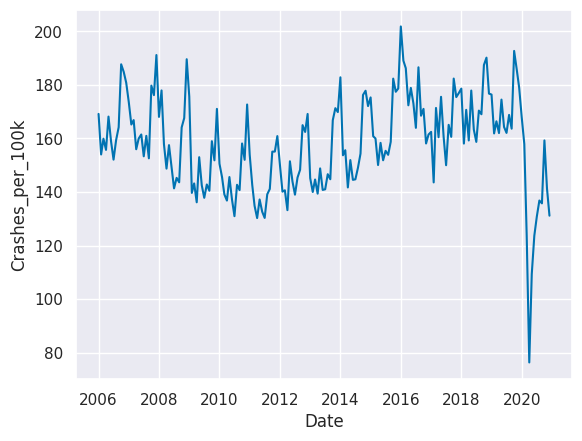

In [25]:
# create line plot
sns.lineplot(data=traffic, x='Date', y='Crashes_per_100k')
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

Looking at the line plot of our collision data, we can see the decreasing trend in crash rates from 2006 continuing until 2010 or 2011, and then crash rates begin increasing. The data for 2020 is very different from the preceding years.
    
There also appear to be cyclical patterns, which may indicate differing crash rates by season.

</details>

### 4. Visualize seasonal rates

Since we saw a fair amount of variance in the number of collisions occurring throughout the year, we might hypothesize that the number of collisions increases or decreases during different seasons. We can visually explore this with a box plot. 

Use `sns.boxplot()` with crash rate on the x-axis and season on the y-axis. Remove the anomolous 2020 data by adjusting the `data` parameter to `traffic[traffic.Date.dt.year != 2020]`.

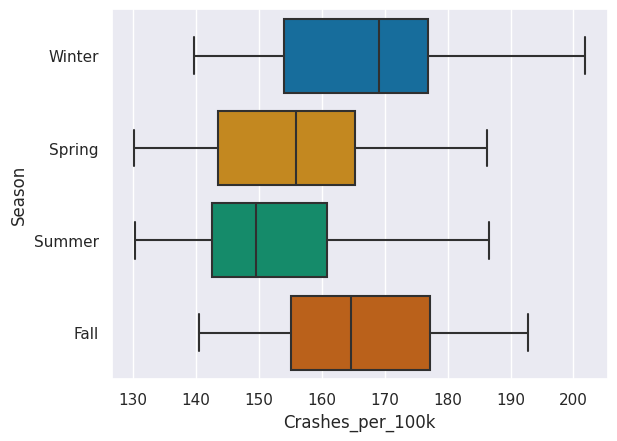

In [26]:
# create box plot by season
sns.boxplot(data=traffic[traffic.Date.dt.year != 2020], x='Crashes_per_100k', y='Season')
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

Winter and Fall appear to have generally higher crash rates than Spring and Summer. Seasons may be the reason for the pattern in crash rates.

</details>

## **Smartphone data exploration**

### 5. Inspect the smartphone use dataset

The dataset `crashes_smartphones.csv` contains smartphone data from Pew Research Center matched to normalized crash rates from the `traffic` data frame for the years 2011 to 2019.

<details>
    <summary style="display:list-item;"><b>Toggle for an overview of the variables in this dataset.</b></summary>

* `Month_Year`: a shortened date with only the month and year of the survey
* `Crashes_per_100k`: the normalized crash rate matching the month and year of the smartphone usage survey
* `Season`: Winter, Spring, Summer, or Fall
* `Smartphone_Survey_Date`: the actual date the smartphone usage survey was conducted
* `Smartphone_usage`: the percent of survey participants that owned and used a smartphone

</details>

Load the dataset as `smartphones` and inspect the first few rows.

In [27]:
# import dataset
smartphones = pd.read_csv('crashes_smartphones.csv')

# inspect first few rows
smartphones.head()

,Month_Year,Crashes_per_100k,Season,Smartphone_Survey_Date,Smartphone_usage
0,Apr-12,133.213685,Spring,4/3/12,46
1,Apr-15,150.077792,Spring,4/12/15,67
2,Apr-16,172.401948,Spring,4/4/16,72
3,Aug-12,145.403147,Summer,8/5/12,44
4,Dec-12,169.160811,Winter,12/9/12,45


### 6. Format date data type
Similar to the  `traffic` data frame, the `smartphones` data frame has a date column that is not properly formatted. Convert the `Smartphone_Survey_Date` column to the date data type using the `pd.to_datetime()` function and then inspect the data types in the data frame.

In [28]:
# change to datetime object
smartphones['Smartphone_Survey_Date'] = pd.to_datetime(smartphones['Smartphone_Survey_Date'])

# inspect data types
smartphones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month_Year              28 non-null     object        
 1   Crashes_per_100k        28 non-null     float64       
 2   Season                  28 non-null     object        
 3   Smartphone_Survey_Date  28 non-null     datetime64[ns]
 4   Smartphone_usage        28 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.2+ KB


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

There is a lot less data available for smartphone usage rates than there was for crash rates. The `smartphones` dataframe consists of 5 columns and 28 rows. Luckily, there are no missing data to contend with.


</details>

### 7. Visualize smartphone use data
Now let's take a look at smartphone use over time. Create a line plot of the `smartphones` data with `Smartphone_Survey_Date` on the x-axis and `Smartphone_usage` on the y-axis.

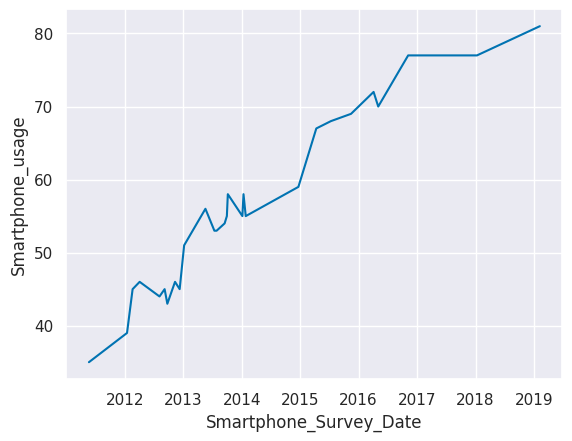

In [29]:
# create line plot
sns.lineplot(data=smartphones, x='Smartphone_Survey_Date', y='Smartphone_usage')
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

We can see a trend of smartphone usage increasing over time.

</details>

## **Relationship exploration**

### 8. Visualize crash rate by smartphone use
A scatter plot with smartphone usage on one axis and crash rates on the other axis will give us an idea of whether there is a relationship between these two variables. 

Create a scatter plot with a regression line using seaborn's `sns.regplot()` with `Smartphone_usage` on the x-axis and `Crashes_per_100k` on the y-axis.

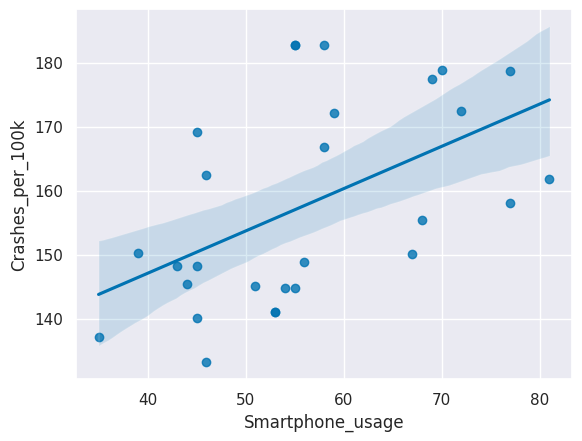

In [30]:
# create scatter plot with regression line
sns.regplot(data=smartphones, x='Smartphone_usage', y='Crashes_per_100k')
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

There appears to be a positive linear relationship between the rate of car crashes and the rate of adult smartphone usage in the U.S.

</details>

### 9. Check the correlation coefficient

To test whether the correlation between `Smartphone_usage` and `Crashes_per_100k` is statistically significant, we can calculate the Pearson's _r_ correlation coefficient and the associated _p_-value. 

Use `corr, p = pearsonr(column1, column2)` on the `Smartphone_usage` and `Crashes_per_100k` columns in the `smartphones` dataframe. Then use the provided code to print `corr` and `p` to see the results.

In [31]:
# find Pearson's r and p-value
corr, p = pearsonr(smartphones['Smartphone_usage'], smartphones['Crashes_per_100k'])

# print corr and p
print("Pearson's r =",  round(corr,3))
print("p = ", round(p,3))

Pearson's r = 0.513
p =  0.005


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

The Pearson's r correlation coefficient is greater than 0.5, which indicates a moderately strong positive relationship. The p-value is less than 0.05. Together, this tells us that there is a statistically significant correlation between adult smartphone usage rates and car crash rates in the U.S. We have to be careful though: correlation does not mean causation, as the saying goes. Many other factors may be contributing to the rise in car crash rates from 2011 to 2019. 

</details>

## **Analysis**

### 10. Run a linear regression
We can use a linear regression to predict crash rates based on smart phone usage. Let's regress crash rates on smartphone usage. Then we can predict the crash rate in 2020 and see if it matches the actual crash rate in 2020!

We have provided the code to convert the variables to NumPy arrays that will work with the modeling function. The `Smartphone_usage` array is saved as `X`, and the `Crashes_per_100k` array is saved as `y`.

Initiate the model by saving `LinearRegression()` to the variable `lm`. Then fit the model and run the regression with `.fit()`.

In [32]:
# convert columns to arrays
X = smartphones['Smartphone_usage'].to_numpy().reshape(-1, 1)
y = smartphones['Crashes_per_100k'].to_numpy().reshape(-1, 1)

In [33]:
lm = LinearRegression()

model = lm.fit(X,y)

### 11. Print and interpret regression coefficients

Let's see the values our model produced. Print the coefficients from our `lm` model. Then think about which parts of the regression line equation these values represent.

In [34]:
# print the coefficients 
# view intercept
print("Intercept: ", model.intercept_[0])

# view coeff
print("Coefficient: ", model.coef_[0][0])

Intercept:  120.66371060130245
Coefficient:  0.6610331584159462


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

The generic equation for a line is `y = b + (m * x)`, where `b` is the value where the the line intercepts the y-axis and `m` is the slope of the line. In this step, we learned the two coefficients of our linear model, `b = 120.6637` and `m = 0.6610`. So the equation for our linear model is `y = 120.6637 + (0.6610 * x)` and we can use this equation to predict new values of y from any new value of x.
    
We can also interpret the slope of 0.6610: every additional percentage point of smartphone usage is associated with an additional 0.6610 crashes per 100,000 people.
</details>

### 12. Make a prediction

Let's assume smartphone usage was the same for 2020 as it was for 2019. This is a reasonable asssumption since the increase in smartphone usage that we observed in our plot started to plateau at the end of the time series. Let's use this approximation and our regression model to predict the crash rate in 2020.

From our model output, the regression line equation is `Crashes_per_100k = 120.6637 + (0.6610 * Smartphone_usage)`. Run the provided code to view the smartphone usage rate for 2019. Then substitute this value into the equation, using Python as a calculator to predict the crash rate for 2020.

In [36]:
# get the smartphone usage rate from 2019
output = smartphones[smartphones['Month_Year'] == "Feb-19"].Smartphone_usage
output

7    81
Name: Smartphone_usage, dtype: int64

In [39]:
# predict the crash rate in 2020 using the regression equation
Crashes_per_100k = 120.6637 + (0.6610 * output)
Crashes_per_100k

7    174.2047
Name: Smartphone_usage, dtype: float64

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

If the smartphone usage rate was the same in 2020 as in 2019 (81%), our model predicts that the crash rate in 2020 would be 174.205 crashes per 100,000 people.  

</details>

### 13. Compare to the actual rate

How good was our prediction? Get the actual crash rate for February of 2020 from the `traffic` dataframe using `pd.to_datetime("2020-02-01")` as the value for `Date`.

In [42]:
# get the actual crash rate in Feb 2020
traffic['Date'] == '2020-02-01'['Crashes_per_100k']

,Date,Crashes_per_100k,Season
0,2006-01-01,169.176541,Winter
1,2006-02-01,154.028836,Winter
2,2006-03-01,159.930002,Spring
3,2006-04-01,155.741270,Spring
4,2006-05-01,168.179208,Spring


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

The actual crash rate in Februrary of 2020 was only 157.8895, which was a fair bit lower than our prediction. 

</details>

### 14. Visualize the prediction

Let's plot our regression plot again, but let's add two new points on top:

* The predicted 2020 crash rate
* The actual 2020 crash rate

Code has been provided for the original regression plot and a legend title. 

Add a scatter plot layer to add the 2020 predicted and actual crash rates that both used the 2019 smartphone usage rate. Use different colors and marker shapes for the predicted and actual 2020 crash rates.

In [ ]:
# recreate the regression plot we made earlier
sns.regplot(x = 'Smartphone_usage', y = 'Crashes_per_100k', data = smartphones)


# add a scatter plot layer to show the actual and predicted 2020 values
## YOUR CODE HERE ##

# add legend title
plt.legend(title='2020')
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

By adding another layer to our regression plot, we can see the difference between the predicted and real crash rates in February 2020. This allows us to see how these values compare to the rest of the dataset. 

</details>